In [ ]:
import statsmodels.tsa.api as smtsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore") 
import sklearn as sk
import pandas as pd
import math as math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import seaborn as sns 
import itertools as it
import time
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import violent crimes dataset into dataframe

In [ ]:
crime_data_df = pd.read_csv("UKViolent_Crimes.csv", index_col=0, parse_dates=True, squeeze=True)
print(type(crime_data_df))
crime_data_df = crime_data_df.iloc[::-1]
crime_data_df

<class 'pandas.core.frame.DataFrame'>


,Month,Total
0,2013-05,57031
1,2013-06,57815
2,2013-07,64962
3,2013-08,61607
4,2013-09,56964
...,...,...
92,2021-01,141414
93,2021-02,135101
94,2021-03,166668
95,2021-04,153789


Time series plot of violent crimes dataset

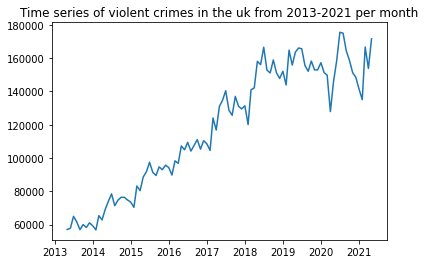

,Month,Total
Month,,
2013-05-01,2013-05-01,57031
2013-06-01,2013-06-01,57815
2013-07-01,2013-07-01,64962
2013-08-01,2013-08-01,61607
2013-09-01,2013-09-01,56964


In [ ]:
crime_data_df.Month = crime_data_df.Month.astype('datetime64[ns]')
crime_data_df_2 = crime_data_df.set_index(pd.to_datetime(crime_data_df.Month))

plt.plot(crime_data_df_2.index, crime_data_df_2['Total'])
plt.title("Time series of violent crimes in the uk from 2013-2021 per month")
plt.show()
crime_data_df_2.head()

Plot the autocorrelation and partial autocorrelation graphs.

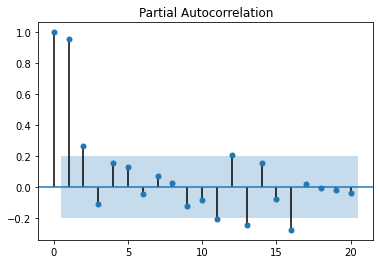

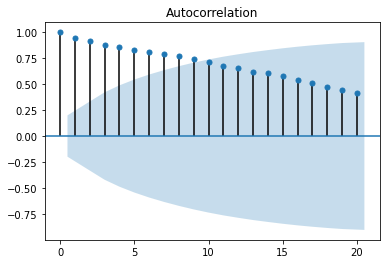

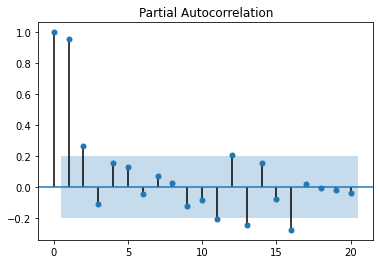

In [ ]:

plot_acf(crime_data_df_2['Total'])
plot_pacf(crime_data_df_2['Total'])

Find the moving average of the data

In [ ]:
#find trend
def find_trend(timeseries):
  trend = timeseries.rolling(window=12, center=True, min_periods=6).mean()

  fig, ax = plt.subplots()
  ax.plot(timeseries)
  ax.plot(trend)
  ax.set_title("Trend of Timeseries against Timeseries")
  plt.show()
  return trend

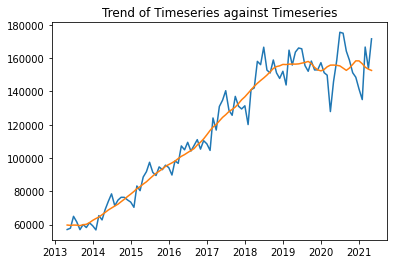

In [ ]:
trend = find_trend(crime_data_df_2['Total'])

Star6t to build ARIMA model on dataset. Perform Detrrending and Differencing on the dataset to make it stationary.

In [ ]:
#test trend with ADF
def test_ADF(timeseries):
  print('Checking if data is stationary')
  adf_results = adfuller(timeseries.dropna(), autolag='AIC')
  print('Test Statistic:', adf_results[0])
  print('P-value:', adf_results[1])
  print('Critical Values :', adf_results[4])
  for key, values in adf_results[4].items():
    if values > adf_results[0] and 0.05 > adf_results[1] :
      print('Test statistic', adf_results[0], 'give stationarity with confidence percentile', 100-int(key[:-1]))
    else:
      print('Test statistic', adf_results[0], 'is greater then the critical value')

In [ ]:
test_ADF(crime_data_df_2['Total'])

Checking if data is stationary
Test Statistic: -1.7573334220429575
P-value: 0.4018405938728145
Critical Values : {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
Test statistic -1.7573334220429575 is greater then the critical value
Test statistic -1.7573334220429575 is greater then the critical value
Test statistic -1.7573334220429575 is greater then the critical value


Detrend the Data and check stationarity

Checking if data is stationary
Test Statistic: -6.127608452131363
P-value: 8.553752935161916e-08
Critical Values : {'1%': -3.510711795769895, '5%': -2.8966159448223734, '10%': -2.5854823866213152}
Test statistic -6.127608452131363 give stationarity with confidence percentile 99
Test statistic -6.127608452131363 give stationarity with confidence percentile 95
Test statistic -6.127608452131363 give stationarity with confidence percentile 90
Month
2013-05-01   -0.857889
2013-06-01   -0.581204
2013-07-01    1.895290
2013-08-01    0.747863
2013-09-01   -0.926302
                ...   
2021-01-01   -1.245810
2021-02-01   -1.655461
2021-03-01    1.008800
2021-04-01    0.033103
2021-05-01    1.463318
Name: Total, Length: 97, dtype: float64


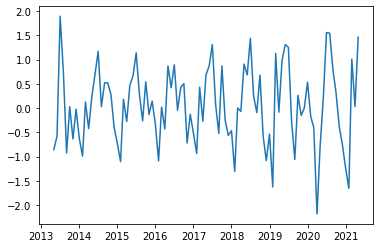

In [ ]:
#Detrend the data and check stationarity
crime_data_detrended = (crime_data_df_2['Total'] - trend)/crime_data_df_2['Total'].rolling(window =12, center=True, min_periods=6).std()

test_ADF(crime_data_detrended)

print(crime_data_detrended)

plt.plot(crime_data_detrended)
plt.show()

Use statsmodels SARIMAX model to implement an SARIMA model. (Brute force approach to find the best order)

In [ ]:
# use auto arima to find the optimal arima model orders for this dataset.
#split the dataset into train and test for arima model

train = crime_data_detrended[:'2019-05-01']
test = crime_data_detrended['2019-06-01':]
print(train)
from collections import defaultdict
start = time.time()
dict_AIC = defaultdict(list)

p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(it.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(it.product(p, d, q))]

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            SARIMAX_model = smtsa.SARIMAX(train,
                          order=order,
                          seasonal_order=seasonal_order,
                          enforce_invertibility=False)
            results = SARIMAX_model.fit()
            print('ARIMA', order, seasonal_order, "AIC:", results.aic)
            dict_AIC[order,seasonal_order].append(results.aic)
        except Exception as e:
            print(e)
            continue
end = time.time()

Month
2013-05-01   -0.857889
2013-06-01   -0.581204
2013-07-01    1.895290
2013-08-01    0.747863
2013-09-01   -0.926302
                ...   
2019-01-01   -0.537165
2019-02-01   -1.626763
2019-03-01    1.128017
2019-04-01   -0.083381
2019-05-01    0.976978
Name: Total, Length: 73, dtype: float64
ARIMA (0, 0, 0) (0, 0, 0, 12) AIC: 160.60155473310928
ARIMA (0, 0, 0) (0, 0, 1, 12) AIC: 139.19450991220145
ARIMA (0, 0, 0) (0, 1, 0, 12) AIC: 87.63995288873674
ARIMA (0, 0, 0) (0, 1, 1, 12) AIC: 81.35889559157445
ARIMA (0, 0, 0) (1, 0, 0, 12) AIC: 112.54515379777764
ARIMA (0, 0, 0) (1, 0, 1, 12) AIC: 107.27899142073947
ARIMA (0, 0, 0) (1, 1, 0, 12) AIC: 77.94338092918203
ARIMA (0, 0, 0) (1, 1, 1, 12) AIC: 79.58590454332412
ARIMA (0, 0, 1) (0, 0, 0, 12) AIC: 160.0805964574856
ARIMA (0, 0, 1) (0, 0, 1, 12) AIC: 140.08843144934986
ARIMA (0, 0, 1) (0, 1, 0, 12) AIC: 89.60346759545185
ARIMA (0, 0, 1) (0, 1, 1, 12) AIC: 82.81263106724374
ARIMA (0, 0, 1) (1, 0, 0, 12) AIC: 114.23911509072745
ARIMA 

The Lowest AIC is the indicator of the best model.

In [ ]:
print('Time taken to find best order:', end-start,'s')

Time taken to find best order: 13.352294683456421 s


In [ ]:
print(dict_AIC)
min_AIC_order = min(dict_AIC, key=dict_AIC.get)
print(min_AIC_order)

defaultdict(<class 'list'>, {((0, 0, 0), (0, 0, 0, 12)): [160.60155473310928], ((0, 0, 0), (0, 0, 1, 12)): [139.19450991220145], ((0, 0, 0), (0, 1, 0, 12)): [87.63995288873674], ((0, 0, 0), (0, 1, 1, 12)): [81.35889559157445], ((0, 0, 0), (1, 0, 0, 12)): [112.54515379777764], ((0, 0, 0), (1, 0, 1, 12)): [107.27899142073947], ((0, 0, 0), (1, 1, 0, 12)): [77.94338092918203], ((0, 0, 0), (1, 1, 1, 12)): [79.58590454332412], ((0, 0, 1), (0, 0, 0, 12)): [160.0805964574856], ((0, 0, 1), (0, 0, 1, 12)): [140.08843144934986], ((0, 0, 1), (0, 1, 0, 12)): [89.60346759545185], ((0, 0, 1), (0, 1, 1, 12)): [82.81263106724374], ((0, 0, 1), (1, 0, 0, 12)): [114.23911509072745], ((0, 0, 1), (1, 0, 1, 12)): [108.25701180874084], ((0, 0, 1), (1, 1, 0, 12)): [79.29825866602155], ((0, 0, 1), (1, 1, 1, 12)): [81.02201201907789], ((0, 1, 0), (0, 0, 0, 12)): [190.90073131321765], ((0, 1, 0), (0, 0, 1, 12)): [176.32601707235867], ((0, 1, 0), (0, 1, 0, 12)): [125.23548647538236], ((0, 1, 0), (0, 1, 1, 12)): [1

Forecast best SARIMAX order model 

Moving Average Lag 1 coefficient: {'trend': 0, 'exog': 0, 'ar': 0, 'ma': 0, 'seasonal_ar': 12, 'seasonal_ma': 0, 'reduced_ar': 12, 'reduced_ma': 0, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}
2019-06-01    0.787714
2019-07-01    1.371360
2019-08-01    0.165695
2019-09-01   -0.323626
2019-10-01    0.783247
2019-11-01   -0.399730
2019-12-01   -0.802669
2020-01-01   -0.499385
2020-02-01   -1.455126
2020-03-01    0.522109
2020-04-01   -0.075117
2020-05-01    0.939725
2020-06-01    0.732427
2020-07-01    1.408568
2020-08-01    0.214576
2020-09-01   -0.199781
2020-10-01    0.727638
2020-11-01   -0.495795
2020-12-01   -0.953494
2021-01-01   -0.519705
2021-02-01   -1.547439
2021-03-01    0.847988
2021-04-01   -0.079562
2021-05-01    0.959761
Freq: MS, dtype: float64


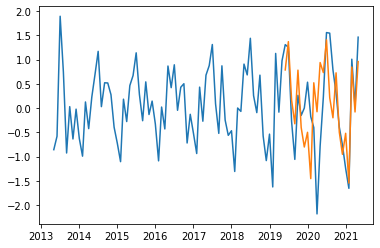

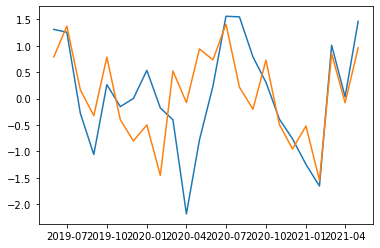

In [ ]:
order = (0,0,0)
seasonal_order = (1,1,0,12)

SARIMA_model_best = smtsa.SARIMAX(train, order=order, seasonal_order=seasonal_order,enforce_invertibility=False)
best_results = SARIMA_model_best.fit()

print("Moving Average Lag 1 coefficient:", best_results.model_orders)

SARIMA_pred = best_results.forecast(steps=24)
print(SARIMA_pred)

fig, ax = plt.subplots()
ax.plot(crime_data_detrended)
ax.plot(SARIMA_pred)
plt.show()

fig, ax = plt.subplots()
ax.plot(crime_data_detrended['2019-06-01':])
ax.plot(SARIMA_pred['2019-06-01':])
plt.show()

PLot diagnostics to show if the data is stationary and normally distributed

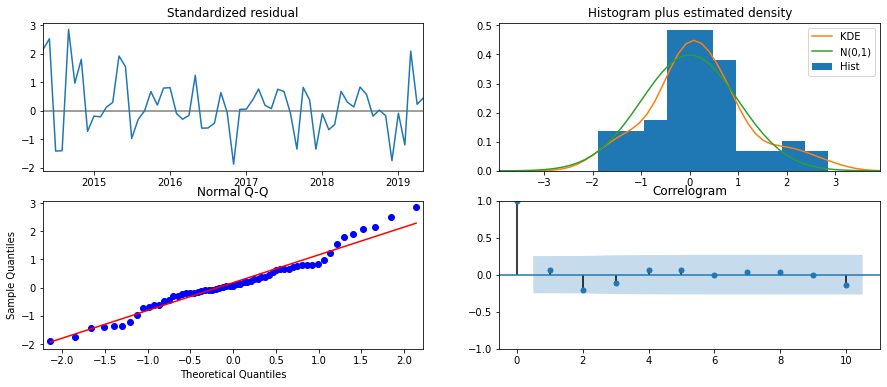

In [ ]:
best_results.plot_diagnostics(figsize=(15,6))
plt.show()

Plot Original data against forecast data


2019-06-01    162299.418940
2019-07-01    166407.594733
2019-08-01    158523.266742
2019-09-01    156218.258846
2019-10-01    161177.636259
2019-11-01    150422.565412
2019-12-01    145016.164632
2020-01-01    147745.264742
2020-02-01    137424.539150
2020-03-01    161338.404788
2020-04-01    154843.529389
2020-05-01    167860.154548
2020-06-01    165101.818435
2020-07-01    173618.033867
2020-08-01    156920.213326
2020-09-01    149743.120557
2020-10-01    165074.240074
2020-11-01    149932.185392
2020-12-01    146019.521256
2021-01-01    151283.618736
2021-02-01    136505.572161
2021-03-01    164742.168749
2021-04-01    152413.573208
2021-05-01    165078.475024
dtype: float64


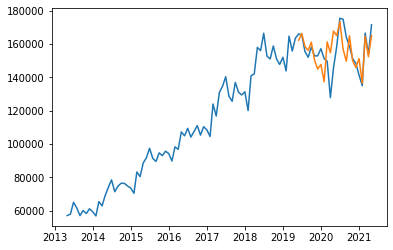

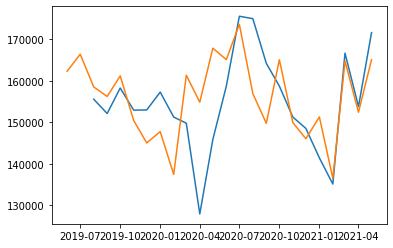

In [ ]:
#recompose data 
recompose_data = SARIMA_pred * crime_data_df_2['Total'].rolling(window =12, center=True, min_periods=6).std() + trend
recompose_data_2 = recompose_data.dropna()
print(recompose_data_2)

fig, ax = plt.subplots()
ax.plot(crime_data_df_2.index, crime_data_df_2['Total'])
ax.plot(recompose_data_2)
plt.show()

fig, ax = plt.subplots()
ax.plot(crime_data_df_2.index[75:], crime_data_df_2['Total'][75:])
plt.plot(recompose_data_2)
plt.show()

In [ ]:
test_rescaled = crime_data_df_2['Total']['2019-06-01':]

rmse = skm.mean_squared_error(test_rescaled,SARIMA_pred, squared=False)
print("Root Mean squared error for 12 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_rescaled,SARIMA_pred)
print("Mean absolute percentage error for 12 forecast steps:", mape)

Root Mean squared error for 12 forecast steps: 156085.57351079973
Mean absolute percentage error for 12 forecast steps: 0.999999659842735


Find all componenets of dataset (trend, seasonality, residuals) using seasonal decomposition from statsmodels

Month
2013-11-01      594.192894
2013-12-01     2333.242746
2014-01-01      -29.269159
2014-02-01     3499.802269
2014-03-01     -570.709635
                  ...     
2020-07-01     9301.897507
2020-08-01    18797.939174
2020-09-01    11071.885603
2020-10-01      655.379650
2020-11-01    -3021.015439
Name: Total, Length: 85, dtype: float64
P value for residual data is: 3.5646796516668074e-11


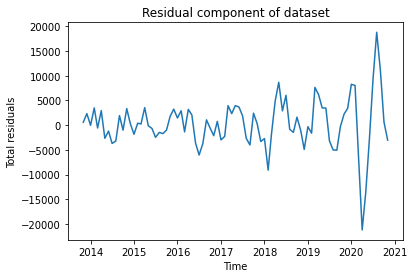

P value for seasonal data is: 0.0


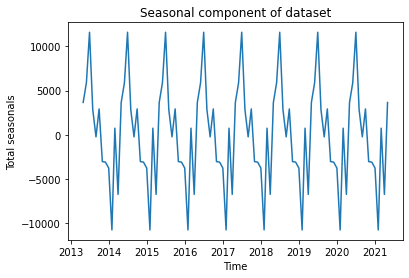

P value for trend data is: 0.47455559423003446


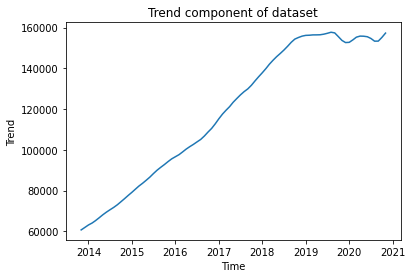

In [ ]:
#decompose the dataset into 
decompose_crime_data = smtsa.seasonal_decompose(crime_data_df_2['Total'], freq=12, model='additive')

#residual adf
residuals = decompose_crime_data.resid
residuals = residuals.dropna()
print(residuals)
adf_result_resid = smtsa.adfuller(residuals, autolag='AIC')
print("P value for residual data is:", adf_result_resid[1])

plt.plot(residuals)
plt.title("Residual component of dataset")
plt.xlabel("Time")
plt.ylabel("Total residuals")
plt.show()

#seasonal adf
seasonal = decompose_crime_data.seasonal
adf_result_seasonal = smtsa.adfuller(seasonal, autolag='AIC')
print("P value for seasonal data is:", adf_result_seasonal[1])

plt.plot(seasonal)
plt.title("Seasonal component of dataset")
plt.xlabel("Time")
plt.ylabel("Total seasonals")
plt.show()

#trend adf
trends = decompose_crime_data.trend
trends = trends.dropna()
adf_result_trend = smtsa.adfuller(trends, autolag='AIC')
print("P value for trend data is:", adf_result_trend[1])

plt.plot(trends)
plt.title("Trend component of dataset")
plt.xlabel("Time")
plt.ylabel("Trend")
plt.show()